In [1]:
import pandas as pd
df = pd.read_csv("../data/pub0225.csv")
code = pd.read_csv("../data/codebook.csv")

In [2]:
# show Non-Null count and Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113780 entries, 0 to 113779
Data columns (total 60 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   REC_NUM   113780 non-null  int64  
 1   SURVYEAR  113780 non-null  int64  
 2   SURVMNTH  113780 non-null  int64  
 3   LFSSTAT   113780 non-null  int64  
 4   PROV      113780 non-null  int64  
 5   CMA       113780 non-null  int64  
 6   AGE_12    113780 non-null  int64  
 7   AGE_6     23176 non-null   float64
 8   GENDER    113780 non-null  int64  
 9   MARSTAT   113780 non-null  int64  
 10  EDUC      113780 non-null  int64  
 11  MJH       65951 non-null   float64
 12  EVERWORK  47829 non-null   float64
 13  FTPTLAST  8062 non-null    float64
 14  COWMAIN   74013 non-null   float64
 15  IMMIG     113780 non-null  int64  
 16  NAICS_21  74013 non-null   float64
 17  NOC_10    74013 non-null   float64
 18  NOC_43    74013 non-null   float64
 19  YABSENT   5527 non-null    float64
 20  WKSA

In [3]:
# Show codebook.csv info
code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Variable      60 non-null     object
 1   EnglishLabel  60 non-null     object
dtypes: object(2)
memory usage: 1.1+ KB


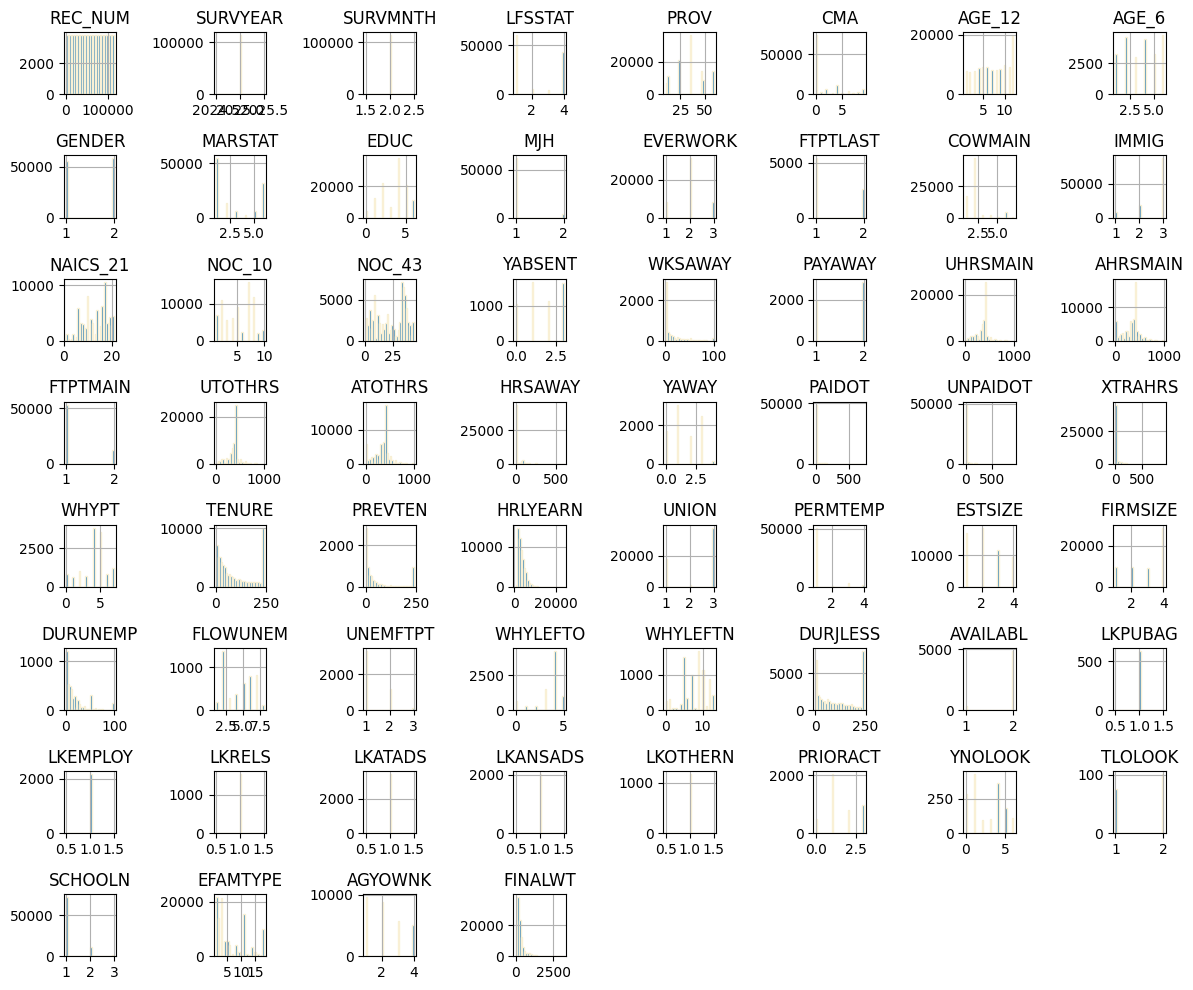

In [4]:
# draw distribution hist
import matplotlib.pyplot as plt

df.hist(figsize=(12, 10), bins=30, edgecolor='#f9f0d5')
plt.tight_layout()
plt.show()

In [5]:
# check target attribute balance
# Note: Labour Force Status attribute indicate the empolyment status. 1 and 2 in LFS attribute mean empolyed while 3 means umemployed.
df['LFSSTAT'].value_counts()

LFSSTAT
1    60424
4    43234
2     5527
3     4595
Name: count, dtype: int64

In [6]:
# To build a classification model, we want to filter only attrbiutes with no more than 40% NA values
percent_missing = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({
    "Missing Values": df.isnull().sum(),
    "Percentage": percent_missing
})
missing_summary = missing_summary.reset_index()
missing_summary.columns.values[0] = "Short Titles"
sorted_missing = missing_summary.sort_values(by="Percentage",ascending=True)
merged_missing = pd.merge(sorted_missing, code, left_on='Short Titles', right_on='Variable')
merged_missing = merged_missing.drop(columns=['Variable'])
merged_missing = merged_missing[["Short Titles","EnglishLabel","Percentage"]][merged_missing["Percentage"] <=40]
print(merged_missing)

Empty DataFrame
Columns: [Short Titles, EnglishLabel, Percentage]
Index: []


In [7]:
# check cardinality: number of unique values
for col in merged_missing["Short Titles"]:
  unique_vals = df[col].nunique(dropna=True)
  if unique_vals <= 50:
    print(f"{col}: {set(df[col].dropna())}")
  else:
    print(f"{col}: {df[col].median()}")

In [8]:
# check the correlation with hourly earnings
print(df.corr()['HRLYEARN'].sort_values(ascending=False))

HRLYEARN    1.000000
AGE_6       0.458356
EDUC        0.364779
ESTSIZE     0.285031
TENURE      0.269112
UHRSMAIN    0.220982
FIRMSIZE    0.220342
UNPAIDOT    0.217880
AGE_12      0.212798
UTOTHRS     0.198638
AHRSMAIN    0.190468
ATOTHRS     0.177323
YAWAY       0.172466
XTRAHRS     0.163938
YABSENT     0.147705
CMA         0.076257
PROV        0.067500
FINALWT     0.036786
IMMIG       0.036272
AGYOWNK     0.034016
PAIDOT      0.027037
HRSAWAY     0.017543
NAICS_21    0.004473
WKSAWAY     0.003136
REC_NUM    -0.000099
LFSSTAT    -0.006813
MJH        -0.033484
WHYPT      -0.066706
UNION      -0.097845
EFAMTYPE   -0.116323
PERMTEMP   -0.116931
GENDER     -0.120926
SCHOOLN    -0.165890
COWMAIN    -0.200171
FTPTMAIN   -0.241291
MARSTAT    -0.249725
PAYAWAY    -0.288297
NOC_10     -0.338047
NOC_43     -0.387219
SURVYEAR         NaN
SURVMNTH         NaN
EVERWORK         NaN
FTPTLAST         NaN
PREVTEN          NaN
DURUNEMP         NaN
FLOWUNEM         NaN
UNEMFTPT         NaN
WHYLEFTO     

Step 0: only keep the relevant attributes for label prediction

In [9]:
df =df[['LFSSTAT','PROV','CMA','AGE_12','EDUC','MARSTAT','IMMIG','EFAMTYPE','SCHOOLN','NOC_10','COWMAIN','NAICS_21','NOC_43']]

Transform the target labels

In [10]:
# Step 1: Filter rows where LFSSTAT is 1, 2, or 3
df = df[df['LFSSTAT'].isin([1, 2, 3])].copy()

# Step 2: Safely map 1 and 2 → 0, and minority 3 → 1
df['LFSSTAT'] = df['LFSSTAT'].apply(lambda x: 0 if x in [1, 2] else 1)

In [11]:
df['LFSSTAT'].value_counts()

LFSSTAT
0    65951
1     4595
Name: count, dtype: int64

Choice 1: drop all the rows with NA values

In [12]:
df_drop = df.copy().dropna()

Choice 2: impute the missing values

Split the dataset early

In [13]:
from sklearn.model_selection import train_test_split

# without stratify, use random_state 42
def data_splitting(df, s=None,random_state=30):
  y = df['LFSSTAT']
  X = df.drop('LFSSTAT', axis=1)

  # Suppose X and y are your features and target variable.
  # First, split off the test set (say 20% or 30% for testing)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random_state,stratify=s)
  return X_train, X_test, y_train, y_test

Step 1: replace the NA values for ordinal category data

Recommended method: Simple median or advanced IterativeImputer + RandomForestRegressor

Clean the training set and apply to testing set

In [14]:
import pandas as pd
from sklearn.impute import SimpleImputer

def impute_ordinal():

  global X_train, X_test

  # List of categorical columns in numerical form

  cols = ['???']

  # Create the imputer using the median strategy
  imputer = SimpleImputer(strategy='median')

  # Fit the imputer on the training set and transform the training, validation, and test sets
  X_train[cols] = imputer.fit_transform(X_train[cols])
  X_test[cols] = imputer.transform(X_test[cols])

  # Convert the imputed columns to integer type (if desired)
  X_train[cols] = X_train[cols].astype(int)
  X_test[cols] = X_test[cols].astype(int)


Step 2: impute the nominal category data, use simple 'most frequent' method

In [15]:
import pandas as pd
from sklearn.impute import SimpleImputer

def impute_nominal():

  global X_train, X_test

  # List of categorical columns in numerical form
  cols = ['NOC_10','SCHOOLN','COWMAIN','NAICS_21','NOC_43']

  # Create the imputer using the most frequent strategy
  imputer = SimpleImputer(strategy='most_frequent')

  # Fit the imputer on the training set and transform the training, validation, and test sets
  X_train[cols] = imputer.fit_transform(X_train[cols])
  X_test[cols] = imputer.transform(X_test[cols])

  # Convert the imputed columns to integer type (if desired)
  X_train[cols] = X_train[cols].astype(int)
  X_test[cols] = X_test[cols].astype(int)


Step 3: preprocess nominal data in case tree model assume it has order. Recommend to use one-hot encoding to convert into binary.

Random Forest in scikit-learn can handle True and False values directly. Technically, no need to convert to 0 and 1.

No additional preprocessing needed if already encoded with integers that reflect the correct order. Random Forest can handle this directly — it treats them as numbers but doesn't assume a linear relationship like regression models do.

If the data is truly nominal, and column has more than 2-3 categories, prefer one-hot encoding for clearer splits. Otherwise, label encoding is okay if you're aware of its limitations.

Label Encoding introduces artificial order, even though none exists.

When you have a categorical feature with many unique values (high cardinality), one-hot encoding can lead to a very wide matrix with many sparse columns. In these cases, binary encoding is a good alternative.

In [16]:
#One-Hot Encode After Imputation for Nominal data

def encode_hot():

  global X_train, X_test

  nominal_cols_all = ['PROV','CMA','NOC_10']

  X_train = pd.get_dummies(X_train, columns=nominal_cols_all, drop_first=True)
  X_test = pd.get_dummies(X_test, columns=nominal_cols_all, drop_first=True)

In [17]:
# A second method for more features:
#One-Hot Encode After Imputation for Nominal data

import category_encoders as ce

def encode_binary():

  global X_train, X_test

  # binary encoding for cardinality columns
  cols_to_encode = ['NAICS_21', 'NOC_43']

  # Initialize the binary encoder
  encoder = ce.BinaryEncoder(cols=cols_to_encode)

  # Fit the encoder and transform the DataFrame
  X_train = encoder.fit_transform(X_train)
  X_test = encoder.fit_transform(X_test)


Build training set and test set, evaluate the prediction by accuracy and AUC

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np

def random_forest_cv(random_state=42, cv=5):
    global X_train, y_train  # Full dataset for cross-validation (assumed to be pandas DataFrame/Series)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    accuracies = []
    aucs = []
    precisions = []
    recalls = []
    f1s = []
    cms = []

    # Loop over each fold
    for train_idx, val_idx in skf.split(X_train, y_train):
        # Use .iloc to select rows by integer index
        X_train_cv = X_train.iloc[train_idx]
        X_val_cv = X_train.iloc[val_idx]
        y_train_cv = y_train.iloc[train_idx]
        y_val_cv = y_train.iloc[val_idx]

        # Train Random Forest on the training fold
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train_cv, y_train_cv)

        # Make predictions on the validation fold
        y_val_pred = model.predict(X_val_cv)
        y_val_proba = model.predict_proba(X_val_cv)[:, 1]  # For AUC

        # Evaluate performance for this fold
        accuracies.append(accuracy_score(y_val_cv, y_val_pred))
        aucs.append(roc_auc_score(y_val_cv, y_val_proba))
        precisions.append(precision_score(y_val_cv, y_val_pred))
        recalls.append(recall_score(y_val_cv, y_val_pred))
        f1s.append(f1_score(y_val_cv, y_val_pred))
        cms.append(confusion_matrix(y_val_cv, y_val_pred))

    # Average the metrics across all folds
    avg_accuracy = np.mean(accuracies)
    avg_auc = np.mean(aucs)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1s)

    print("Average Cross-Validation Metrics:")
    print("Accuracy:", avg_accuracy)
    print("AUC:", avg_auc)
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1-Score:", avg_f1)
    #print("Confusion Matrices for each fold:")
    #for i, cm in enumerate(cms, 1):
    #    print("Fold", i, ":\n", cm)

    #return avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1


Compare the random forest result by dropping and imputation

In [19]:
# by dropping

X_train, X_test, y_train, y_test = data_splitting(df_drop)
encode_hot()
encode_binary()
print("random forest + dropping:")
random_forest_cv()

random forest + dropping:
Average Cross-Validation Metrics:
Accuracy: 0.9613598489056772
AUC: 0.8633243189599563
Precision: 0.6236726886552358
Recall: 0.11373626373626373
F1-Score: 0.19229775351730313


In [20]:
# by imputation
X_train, X_test, y_train, y_test = data_splitting(df,None,42)
impute_nominal()
encode_hot()
encode_binary()
print("random forest + imputation")
random_forest_cv()

random forest + imputation
Average Cross-Validation Metrics:
Accuracy: 0.9614029332765475
AUC: 0.9193400622397858
Precision: 0.8804518676095885
Recall: 0.479712631454567
F1-Score: 0.6207644884234329


In [21]:
# No imputation
X_train, X_test, y_train, y_test = data_splitting(df,None,42)
encode_hot()
encode_binary()
print("random forest + no imputation")
random_forest_cv()

random forest + no imputation
Average Cross-Validation Metrics:
Accuracy: 0.9632862048477767
AUC: 0.921945300283266
Precision: 0.9269491327690126
Recall: 0.48093961952026465
F1-Score: 0.6330211670750645


In [22]:
print("random forest + imputation + new seed")
random_forest_cv(100)

random forest + imputation + new seed
Average Cross-Validation Metrics:
Accuracy: 0.9630431996833633
AUC: 0.9219912441772046
Precision: 0.9275534264382601
Recall: 0.4766475245184923
F1-Score: 0.6292590803453397


The results showed imputation is better than purely dropping data in random forest this time

Compare data splitting with stratify or without

In [23]:
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
impute_nominal()
encode_hot()
encode_binary()
print("random forest + imputation + stratify")
random_forest_cv()

random forest + imputation + stratify
Average Cross-Validation Metrics:
Accuracy: 0.9609776824401459
AUC: 0.9159990400390065
Precision: 0.8615888529948611
Recall: 0.47792326342938285
F1-Score: 0.6145902790956375


The result with and without stratify does not change much

Compare random forest with XGBoost model, which build trees one after another

In [24]:
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np

def xgboost_cv(random_state=100, cv=5, print_feature_importance=False):
    global X_train, y_train  # Full dataset for cross-validation (assumed to be a pandas DataFrame/Series)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    accuracies = []
    aucs = []
    precisions = []
    recalls = []
    f1s = []
    cms = []

    # List to accumulate feature importances from each fold
    xgb_importances_list = []

    # Loop over each fold
    for train_idx, val_idx in skf.split(X_train, y_train):
        # Use .iloc for proper indexing with pandas DataFrames/Series
        X_train_cv = X_train.iloc[train_idx]
        X_val_cv = X_train.iloc[val_idx]
        y_train_cv = y_train.iloc[train_idx]
        y_val_cv = y_train.iloc[val_idx]

        # Initialize the XGBoost classifier
        model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train_cv, y_train_cv)

        # Accumulate the feature importances from this fold
        xgb_importances_list.append(model.feature_importances_)

        # Make predictions on the validation fold
        y_val_pred = model.predict(X_val_cv)
        y_val_proba = model.predict_proba(X_val_cv)[:, 1]

        # Evaluate performance for this fold
        accuracies.append(accuracy_score(y_val_cv, y_val_pred))
        aucs.append(roc_auc_score(y_val_cv, y_val_proba))
        precisions.append(precision_score(y_val_cv, y_val_pred))
        recalls.append(recall_score(y_val_cv, y_val_pred))
        f1s.append(f1_score(y_val_cv, y_val_pred))
        cms.append(confusion_matrix(y_val_cv, y_val_pred))

    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_auc = np.mean(aucs)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1s)

    # Average feature importances over folds
    xgb_importances_avg = np.mean(xgb_importances_list, axis=0)
    if isinstance(X_train, pd.DataFrame):
        xgb_feature_importance = pd.Series(xgb_importances_avg, index=X_train.columns)
    else:
        xgb_feature_importance = xgb_importances_avg

    # Print performance metrics
    print("Average Cross-Validation Metrics:")
    print("Accuracy:", avg_accuracy)
    print("AUC:", avg_auc)
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1-Score:", avg_f1)

    # Optionally print the feature importances
    if print_feature_importance:
        print("\nAverage Feature Importance from XGBoost:")
        print(xgb_feature_importance.sort_values(ascending=False))
        return xgb_feature_importance.sort_values(ascending=False)
    else:
        return avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1

    #print("\nConfusion Matrices for each fold:")
    #for i, cm in enumerate(cms, 1):
    #    print("Fold", i, ":\n", cm)

In [25]:
# by dropping

X_train, X_test, y_train, y_test = data_splitting(df_drop)
encode_hot()
encode_binary()
print("XGBoost + dropping:")
xgboost_cv()

XGBoost + dropping:
Average Cross-Validation Metrics:
Accuracy: 0.9643595156093767
AUC: 0.8966756555936828
Precision: 0.6658663226912677
Recall: 0.24065934065934064
F1-Score: 0.35302633714014864


(np.float64(0.9643595156093767),
 np.float64(0.8966756555936828),
 np.float64(0.6658663226912677),
 np.float64(0.24065934065934064),
 np.float64(0.35302633714014864))

In [26]:
print("XGBoost + imputation")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
impute_nominal()
encode_hot()
encode_binary()
xgboost_cv()

XGBoost + imputation
Average Cross-Validation Metrics:
Accuracy: 0.9655744966449008
AUC: 0.9390740314067495
Precision: 0.8691183686565941
Recall: 0.5553456719762758
F1-Score: 0.6774505818458365


(np.float64(0.9655744966449008),
 np.float64(0.9390740314067495),
 np.float64(0.8691183686565941),
 np.float64(0.5553456719762758),
 np.float64(0.6774505818458365))

In [27]:
print("XGBoost + no imputation")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
encode_hot()
encode_binary()
xgboost_cv()

XGBoost + no imputation
Average Cross-Validation Metrics:
Accuracy: 0.967093264570171
AUC: 0.9403510571523757
Precision: 0.9077417060516119
Recall: 0.55068294002299
F1-Score: 0.6854161891277142


(np.float64(0.967093264570171),
 np.float64(0.9403510571523757),
 np.float64(0.9077417060516119),
 np.float64(0.55068294002299),
 np.float64(0.6854161891277142))

This is interesting, the XGBoost model performs better when we keep the NA values

In [28]:
print("XGBoost + no imputation + no stratify")
X_train, X_test, y_train, y_test = data_splitting(df,None,42)
encode_hot()
encode_binary()
xgboost_cv()

XGBoost + no imputation + no stratify
Average Cross-Validation Metrics:
Accuracy: 0.9663642613789136
AUC: 0.9384720743944349
Precision: 0.9016561230966001
Recall: 0.5497847099137422
F1-Score: 0.6828138261232446


(np.float64(0.9663642613789136),
 np.float64(0.9384720743944349),
 np.float64(0.9016561230966001),
 np.float64(0.5497847099137422),
 np.float64(0.6828138261232446))

Ensemble random forest and XGBoost

In [29]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

def ensemble_rf_xgb_cv(random_state=42, cv=5):
    global X_train, y_train  # Full dataset for cross-validation (assumed to be pandas DataFrame/Series)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    accuracies = []
    aucs = []
    precisions = []
    recalls = []
    f1s = []
    cms = []

    # Loop over each fold
    for train_idx, val_idx in skf.split(X_train, y_train):
        # Use .iloc for proper indexing
        X_train_cv = X_train.iloc[train_idx]
        X_val_cv = X_train.iloc[val_idx]
        y_train_cv = y_train.iloc[train_idx]
        y_val_cv = y_train.iloc[val_idx]

        # Initialize the base models with default hyperparameters
        rf = RandomForestClassifier(random_state=random_state)
        xgb = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')

        # Create a VotingClassifier ensemble with soft voting (averages probabilities)
        ensemble_model = VotingClassifier(
            estimators=[('rf', rf), ('xgb', xgb)],
            voting='soft'
        )

        # Train the ensemble on the training fold
        ensemble_model.fit(X_train_cv, y_train_cv)

        # Make predictions on the validation fold
        y_val_pred = ensemble_model.predict(X_val_cv)
        y_val_proba = ensemble_model.predict_proba(X_val_cv)[:, 1]

        # Evaluate performance for this fold
        accuracies.append(accuracy_score(y_val_cv, y_val_pred))
        aucs.append(roc_auc_score(y_val_cv, y_val_proba))
        precisions.append(precision_score(y_val_cv, y_val_pred))
        recalls.append(recall_score(y_val_cv, y_val_pred))
        f1s.append(f1_score(y_val_cv, y_val_pred))
        cms.append(confusion_matrix(y_val_cv, y_val_pred))

    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_auc = np.mean(aucs)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1s)

    print("Average Cross-Validation Metrics:")
    print("Accuracy:", avg_accuracy)
    print("AUC:", avg_auc)
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1-Score:", avg_f1)
    #print("Confusion Matrices for each fold:")
    #for i, cm in enumerate(cms, 1):
    #    print("Fold", i, ":\n", cm)

    #return avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1


In [30]:
print("Ensemble + no imputation")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
encode_hot()
encode_binary()
ensemble_rf_xgb_cv(100)

Ensemble + no imputation
Average Cross-Validation Metrics:
Accuracy: 0.9672957736579532
AUC: 0.9399660627148293
Precision: 0.945403348185265
Recall: 0.5282951614617041
F1-Score: 0.677786282462787


The ensemble does not improve much

After this, we would more focus on XGBoosting method

Select the key features by XGBoost feature importance

In [31]:
print("Feature importance on XGBoost + no imputation")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
encode_hot()
encode_binary()
importance_list = xgboost_cv(print_feature_importance=True)

Feature importance on XGBoost + no imputation
Average Cross-Validation Metrics:
Accuracy: 0.967093264570171
AUC: 0.9403510571523757
Precision: 0.9077417060516119
Recall: 0.55068294002299
F1-Score: 0.6854161891277142

Average Feature Importance from XGBoost:
COWMAIN        0.490948
MARSTAT        0.052532
EFAMTYPE       0.040057
NOC_10_9.0     0.029661
NOC_10_4.0     0.022475
NOC_10_8.0     0.018500
NOC_10_5.0     0.017159
NOC_43_0       0.016045
NOC_10_2.0     0.013219
PROV_11        0.011678
NAICS_21_1     0.011621
AGE_12         0.010968
NOC_43_4       0.010007
NOC_10_6.0     0.009983
NAICS_21_3     0.009880
PROV_13        0.009511
NOC_43_2       0.009418
NAICS_21_2     0.009384
NOC_10_3.0     0.009296
CMA_2          0.009217
CMA_9          0.008869
NAICS_21_4     0.008647
NOC_43_3       0.008590
NOC_43_5       0.008473
NOC_43_1       0.008425
PROV_24        0.008394
CMA_3          0.008343
PROV_59        0.008267
NOC_10_7.0     0.008090
NAICS_21_0     0.007910
CMA_6          0.00787

In [32]:
cumulative_importance = importance_list.cumsum()

# Select features until cumulative importance exceeds, say, 80%
selected_features = cumulative_importance[cumulative_importance <= 0.80].index.tolist()
print("Number of features selected:", len(selected_features))
print("Selected features:", selected_features)

Number of features selected: 18
Selected features: ['COWMAIN', 'MARSTAT', 'EFAMTYPE', 'NOC_10_9.0', 'NOC_10_4.0', 'NOC_10_8.0', 'NOC_10_5.0', 'NOC_43_0', 'NOC_10_2.0', 'PROV_11', 'NAICS_21_1', 'AGE_12', 'NOC_43_4', 'NOC_10_6.0', 'NAICS_21_3', 'PROV_13', 'NOC_43_2', 'NAICS_21_2']


In [33]:
X_train.shape

(49382, 45)

Use seleceted features to run XGBoosting

In [34]:
print("Feature importance on XGBoost + no imputation")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
encode_hot()
encode_binary()
X_train,X_test = X_train[selected_features],X_test[selected_features]
xgboost_cv()

Feature importance on XGBoost + no imputation
Average Cross-Validation Metrics:
Accuracy: 0.9677615041683423
AUC: 0.9391984021462145
Precision: 0.9152043567994188
Recall: 0.5565898399389508
F1-Score: 0.6921400014402082


(np.float64(0.9677615041683423),
 np.float64(0.9391984021462145),
 np.float64(0.9152043567994188),
 np.float64(0.5565898399389508),
 np.float64(0.6921400014402082))

Choosing feature according to importance indeed improves the F1-Score

In [35]:
# try to find best top features in XGBoost
def select_xgb_features():
    global cumulative_importance, df, X_train, X_test, y_train, y_test
    thresholds = list(np.arange(0.5, 1.00, 0.05))

    results = []
    for t in thresholds:

        selected_features = cumulative_importance[cumulative_importance <= t].index.tolist()

        # Assign to the global variables
        X_train, X_test, y_train, y_test = data_splitting(df, df['LFSSTAT'], 42)
        encode_hot()
        encode_binary()
        X_train, X_test = X_train[selected_features], X_test[selected_features]
        avg_accuracy, avg_auc, avg_precision, avg_recall, avg_f1 = xgboost_cv()

        result = {
            "thresholds": t,
            "feature_num": len(selected_features),
            "accuracy": avg_accuracy,
            "auc": avg_auc,
            "precision": avg_precision,
            "recall": avg_recall,
            "f1": avg_f1
        }

        results.append(result)

    results_df = pd.DataFrame(results)
    return results_df


In [36]:
select_xgb_features()

Average Cross-Validation Metrics:
Accuracy: 0.96142319054135
AUC: 0.783624146742024
Precision: 1.0
Recall: 0.4076466099320924
F1-Score: 0.5791359359136055
Average Cross-Validation Metrics:
Accuracy: 0.96142319054135
AUC: 0.8117260347525155
Precision: 1.0
Recall: 0.4076466099320924
F1-Score: 0.5791359359136055
Average Cross-Validation Metrics:
Accuracy: 0.9656150009228537
AUC: 0.9170184638969584
Precision: 0.9698976766457464
Recall: 0.4872492103204119
F1-Score: 0.6485035948494446
Average Cross-Validation Metrics:
Accuracy: 0.9657162626429013
AUC: 0.9231848492859971
Precision: 0.96057723839614
Recall: 0.49408971919283634
F1-Score: 0.6523228402233857
Average Cross-Validation Metrics:
Accuracy: 0.967376782213859
AUC: 0.9307862053999327
Precision: 0.9313158881503554
Recall: 0.538867691237696
F1-Score: 0.6826170097659169
Average Cross-Validation Metrics:
Accuracy: 0.9676602691025904
AUC: 0.9361712180718984
Precision: 0.9262607267736502
Recall: 0.5469518850883379
F1-Score: 0.6877464812945566


,thresholds,feature_num,accuracy,auc,precision,recall,f1
0,0.50,1,0.961423,0.783624,1.000000,0.407647,0.579136
1,0.55,2,0.961423,0.811726,1.000000,0.407647,0.579136
2,0.60,3,0.965615,0.917018,0.969898,0.487249,0.648504
3,0.65,5,0.965716,0.923185,0.960577,0.494090,0.652323
4,0.70,8,0.967377,0.930786,0.931316,0.538868,0.682617
5,0.75,13,0.967660,0.936171,0.926261,0.546952,0.687746
6,0.80,18,0.967762,0.939198,0.915204,0.556590,0.692140
7,0.85,24,0.968146,0.941612,0.916003,0.562498,0.696906
8,0.90,30,0.967903,0.942083,0.913218,0.560637,0.694616
9,0.95,37,0.967620,0.940030,0.912374,0.556278,0.691014


From the result, setting a threshold of 0.85 is better, the chosen features are 27 out of 45, and the best F1 value is 0.697465

In [37]:
cumulative_importance = importance_list.cumsum()
highest_features = cumulative_importance[cumulative_importance <= 0.85].index.tolist()
print(len(highest_features))
print(highest_features)

24
['COWMAIN', 'MARSTAT', 'EFAMTYPE', 'NOC_10_9.0', 'NOC_10_4.0', 'NOC_10_8.0', 'NOC_10_5.0', 'NOC_43_0', 'NOC_10_2.0', 'PROV_11', 'NAICS_21_1', 'AGE_12', 'NOC_43_4', 'NOC_10_6.0', 'NAICS_21_3', 'PROV_13', 'NOC_43_2', 'NAICS_21_2', 'NOC_10_3.0', 'CMA_2', 'CMA_9', 'NAICS_21_4', 'NOC_43_3', 'NOC_43_5']


Try undersampling and oversampling to XGBoost model

In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# Import sampling methods from imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

def test_sampling_methods_xgb(random_state=100, cv=5, ratio_grid=[0.5, 0.7, 1.0]):
    """
    Tests different sampling methods (oversample, undersample, combined) with a grid of sampling ratios.
    Uses stratified cross-validation with XGBoost, and prints average metrics for each configuration.

    """
    global X_train, y_train  # full dataset

    # Define a dictionary of sampling methods with lambdas that accept a sampling_strategy parameter.
    sampling_methods = {
        "oversample": lambda ratio: SMOTE(sampling_strategy=ratio, random_state=random_state),
        "undersample": lambda ratio: RandomUnderSampler(sampling_strategy=ratio, random_state=random_state),
        "combined": lambda ratio: SMOTETomek(sampling_strategy=ratio, random_state=random_state)
    }

    # Prepare a results list to accumulate results
    results = []

    # Loop over each sampling method
    for method_name, sampler_fn in sampling_methods.items():
        for ratio in ratio_grid:
            skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

            accuracies = []
            aucs = []
            precisions = []
            recalls = []
            f1s = []
            cms = []

            # Loop over CV folds
            for train_idx, val_idx in skf.split(X_train, y_train):
                # Use .iloc for pandas DataFrame/Series indexing
                X_train_cv = X_train.iloc[train_idx]
                X_val_cv = X_train.iloc[val_idx]
                y_train_cv = y_train.iloc[train_idx]
                y_val_cv = y_train.iloc[val_idx]

                # Initialize the sampler using the current method and ratio
                sampler = sampler_fn(ratio)
                # Resample the training data (note: sampler works with numpy arrays as well)
                X_res, y_res = sampler.fit_resample(X_train_cv, y_train_cv)

                # Initialize and train the XGBoost classifier
                model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')
                model.fit(X_res, y_res)

                # Predict on the validation fold (without resampling)
                y_val_pred = model.predict(X_val_cv)
                y_val_proba = model.predict_proba(X_val_cv)[:, 1]

                # Evaluate metrics for this fold
                accuracies.append(accuracy_score(y_val_cv, y_val_pred))
                aucs.append(roc_auc_score(y_val_cv, y_val_proba))
                precisions.append(precision_score(y_val_cv, y_val_pred))
                recalls.append(recall_score(y_val_cv, y_val_pred))
                f1s.append(f1_score(y_val_cv, y_val_pred))
                cms.append(confusion_matrix(y_val_cv, y_val_pred))

            # Average metrics over folds
            avg_accuracy = np.mean(accuracies)
            avg_auc = np.mean(aucs)
            avg_precision = np.mean(precisions)
            avg_recall = np.mean(recalls)
            avg_f1 = np.mean(f1s)

            # Save result in a dictionary
            result = {
                "method": method_name,
                "ratio": ratio,
                "accuracy": avg_accuracy,
                "auc": avg_auc,
                "precision": avg_precision,
                "recall": avg_recall,
                "f1": avg_f1
            }
            results.append(result)

            # Print the results for this configuration
            print(f"Method: {method_name}, Ratio: {ratio}")
            print("Average CV Metrics:")
            print(f"  Accuracy: {avg_accuracy:.4f}")
            print(f"  AUC:      {avg_auc:.4f}")
            print(f"  Precision:{avg_precision:.4f}")
            print(f"  Recall:   {avg_recall:.4f}")
            print(f"  F1-Score: {avg_f1:.4f}")
            print("-"*40)

    results_df = pd.DataFrame(results)
    return results_df

In [39]:
print("Oversampling and undersampling XGBoost + imputation")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
impute_nominal()
encode_hot()
encode_binary()
test_sampling_methods_xgb()

Oversampling and undersampling XGBoost + imputation
Method: oversample, Ratio: 0.5
Average CV Metrics:
  Accuracy: 0.9558
  AUC:      0.9311
  Precision:0.6911
  Recall:   0.5799
  F1-Score: 0.6306
----------------------------------------
Method: oversample, Ratio: 0.7
Average CV Metrics:
  Accuracy: 0.9539
  AUC:      0.9303
  Precision:0.6643
  Recall:   0.5924
  F1-Score: 0.6262
----------------------------------------
Method: oversample, Ratio: 1.0
Average CV Metrics:
  Accuracy: 0.9507
  AUC:      0.9285
  Precision:0.6271
  Recall:   0.5980
  F1-Score: 0.6122
----------------------------------------
Method: undersample, Ratio: 0.5
Average CV Metrics:
  Accuracy: 0.9039
  AUC:      0.9343
  Precision:0.3791
  Recall:   0.7441
  F1-Score: 0.5022
----------------------------------------
Method: undersample, Ratio: 0.7
Average CV Metrics:
  Accuracy: 0.8711
  AUC:      0.9329
  Precision:0.3090
  Recall:   0.7917
  F1-Score: 0.4444
----------------------------------------
Method: und

,method,ratio,accuracy,auc,precision,recall,f1
0,oversample,0.5,0.955753,0.931146,0.691129,0.579910,0.630603
1,oversample,0.7,0.953910,0.930330,0.664349,0.592351,0.626156
2,oversample,1.0,0.950650,0.928482,0.627118,0.597951,0.612156
3,undersample,0.5,0.903912,0.934291,0.379088,0.744089,0.502234
4,undersample,0.7,0.871066,0.932906,0.308964,0.791660,0.444422
5,undersample,1.0,0.828541,0.929624,0.253543,0.839857,0.389495
6,combined,0.5,0.956057,0.930845,0.696139,0.577734,0.631347
7,combined,0.7,0.954720,0.930041,0.673789,0.591727,0.629968
8,combined,1.0,0.950832,0.929204,0.629124,0.598258,0.613211


Seems that the oversampling and undersampling did not improve the F1-score as expected

Lets try to adjust threshold to see the difference

In [40]:
import numpy as np
from sklearn.metrics import f1_score

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

def xgboost_cv_with_threshold(random_state=100, cv=5, threshold_grid=np.arange(0.1, 0.9, 0.05)):
    global X_train, y_train

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    # Lists to store metrics for each fold
    accuracies = []
    aucs = []
    precisions = []
    recalls = []
    f1s = []
    cms = []

    # For threshold search
    default_f1_scores = []  # F1 scores at default threshold 0.5
    best_thresholds = []     # Best threshold found in each fold
    best_f1_scores = []      # Best F1 score achieved in each fold

    # Loop over each fold
    for train_idx, val_idx in skf.split(X_train, y_train):
        # Use .iloc for proper indexing with pandas DataFrames/Series
        X_train_cv = X_train.iloc[train_idx]
        X_val_cv = X_train.iloc[val_idx]
        y_train_cv = y_train.iloc[train_idx]
        y_val_cv = y_train.iloc[val_idx]

        # Initialize the XGBoost classifier
        model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train_cv, y_train_cv)

        # Get predictions on the validation fold
        y_val_proba = model.predict_proba(X_val_cv)[:, 1]
        y_val_pred_default = (y_val_proba >= 0.5).astype(int)

        # Evaluate default threshold metrics
        default_f1 = f1_score(y_val_cv, y_val_pred_default)
        default_f1_scores.append(default_f1)

        # Search for the best threshold based on F1 score
        best_f1 = -1
        best_thresh = None
        for thresh in threshold_grid:
            y_val_pred = (y_val_proba >= thresh).astype(int)
            curr_f1 = f1_score(y_val_cv, y_val_pred)
            if curr_f1 > best_f1:
                best_f1 = curr_f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
        best_f1_scores.append(best_f1)

        # Optionally, compute other metrics at default threshold
        accuracies.append(accuracy_score(y_val_cv, y_val_pred_default))
        aucs.append(roc_auc_score(y_val_cv, y_val_proba))
        precisions.append(precision_score(y_val_cv, y_val_pred_default))
        recalls.append(recall_score(y_val_cv, y_val_pred_default))
        f1s.append(default_f1)
        cms.append(confusion_matrix(y_val_cv, y_val_pred_default))

    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_auc = np.mean(aucs)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1_default = np.mean(f1s)

    # Average threshold search results
    avg_best_threshold = np.mean(best_thresholds)
    avg_best_f1 = np.mean(best_f1_scores)

    # Print performance metrics
    print("Average Cross-Validation Metrics (Default threshold=0.5):")
    print("  Accuracy:", avg_accuracy)
    print("  AUC:", avg_auc)
    print("  Precision:", avg_precision)
    print("  Recall:", avg_recall)
    print("  F1-Score:", avg_f1_default)
    print("\nThreshold Search Results:")
    print("  Average Default F1 Score (0.5):", np.mean(default_f1_scores))
    print("  Average Best Threshold:", avg_best_threshold)
    print("  Average Best F1 Score:", avg_best_f1)

    return avg_best_threshold

In [41]:
print("Find a better threshold for XGBoost + no imputation + highest features")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
encode_hot()
encode_binary()
X_train,X_test = X_train[highest_features],X_test[highest_features]
xgboost_cv_with_threshold()

Find a better threshold for XGBoost + no imputation + highest features
Average Cross-Validation Metrics (Default threshold=0.5):
  Accuracy: 0.9681462753307561
  AUC: 0.9416118426211606
  Precision: 0.9160030715857961
  Recall: 0.5624977058238265
  F1-Score: 0.6969058059758643

Threshold Search Results:
  Average Default F1 Score (0.5): 0.6969058059758643
  Average Best Threshold: 0.45000000000000007
  Average Best F1 Score: 0.7004016491376496


np.float64(0.45000000000000007)

Using 0.46 as a threshold, mprove 0.6974 to 0.6990

Using grid search and k-fold cross validation to find the best XGBoost hyperparameter, this takes long time

In [42]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import numpy as np

# Custom estimator that uses a fixed threshold (0.46) for predictions.
class XGBClassifierWithThreshold(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.46, **kwargs):
        """
        Parameters:
          threshold: The probability cutoff for classifying an instance as positive (fixed to 0.46 here).
          **kwargs: Other parameters for the underlying XGBClassifier.
        """
        self.threshold = threshold
        self.kwargs = kwargs
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X):
        # Use the fixed threshold (0.46) to convert predicted probabilities into binary predictions.
        prob = self.predict_proba(X)[:, 1]
        return (prob >= self.threshold).astype(int)

    def get_params(self, deep=True):
        # Include threshold along with the XGB parameters so that GridSearchCV can see them.
        params = {"threshold": self.threshold}
        params.update(self.kwargs)
        return params

    def set_params(self, **parameters):
        if "threshold" in parameters:
            self.threshold = parameters.pop("threshold")
        self.kwargs.update(parameters)
        self.model = XGBClassifier(**self.kwargs)
        return self

def find_xgb_hp(random_state=100):
    global X_train, y_train

    # Define a parameter grid (excluding threshold because it's fixed at 0.46).
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    # Define a scorer using F1 score.
    f1_scorer = make_scorer(f1_score)

    # Initialize the custom XGBoost classifier with a fixed threshold of 0.46.
    model = XGBClassifierWithThreshold(
        random_state=random_state,
        use_label_encoder=False,
        eval_metric='logloss',
        threshold=0.46
    )

    # Set up GridSearchCV with 5-fold cross-validation.
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Fit GridSearchCV to the training data (assumes X_train and y_train are defined).
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding F1 score.
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best CV F1-Score:", grid_search.best_score_)

In [43]:
print("Find best hyperparameters for XGBoost + no imputation + highest features")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
encode_hot()
encode_binary()
X_train,X_test = X_train[highest_features],X_test[highest_features]
find_xgb_hp()

Find best hyperparameters for XGBoost + no imputation + highest features
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estima

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=5

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimato

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estima

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.0s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimator

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.9s

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estima

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.8s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=1

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsamp

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsamp

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=200, subsam

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsamp

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.6s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsa

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.1s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=20

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=5

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsamp

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsa

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsamp

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s



/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, su

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsampl

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.6s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsa

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s



/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.8s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimator

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estima

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=20

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.8s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.8s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.5s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimator

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=2

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.6s[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.6s

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsam

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsampl

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subs

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsampl

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsam

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.3s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.9s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsamp

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.5s


/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=50, subsa

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100,

/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:43:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/xiaochen/miniconda3/lib/python3.13

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200,

Final evluation on test set

In [44]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def xgboost_evaluate(random_state=100, print_feature_importance=False):
    global X_train, y_train, X_test, y_test  # Assumes X_train, y_train, X_test, y_test are already defined

    # Initialize the XGBoost classifier with the specified hyperparameters
    model = XGBClassifier(
        random_state=random_state,
        use_label_encoder=False,
        eval_metric='logloss',
        colsample_bytree=1.0,
        learning_rate=0.1,
        max_depth=7,
        n_estimators=200,
        subsample=0.8
    )

    # Train on the full training set
    model.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_proba)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)

    # Print performance metrics
    print("Test Set Metrics:")
    print("Accuracy:", accuracy)
    print("AUC:", auc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Plot feature importance bar chart if requested
    if print_feature_importance:
        if isinstance(X_train, pd.DataFrame):
            feat_importance = pd.Series(model.feature_importances_, index=X_train.columns)
        else:
            feat_importance = model.feature_importances_
        feat_importance = feat_importance.sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        feat_importance.plot(kind='bar')
        plt.title('Feature Importance')
        plt.ylabel('Importance')
        plt.show()

    return model, accuracy, auc, precision, recall, f1, cm


Final evaluation on test set for XGBoost + no imputation + highest features
Test Set Metrics:
Accuracy: 0.9671612171612172
AUC: 0.9283312102564498
Precision: 0.9318181818181818
Recall: 0.5351704133430022
F1-Score: 0.6798710271764163


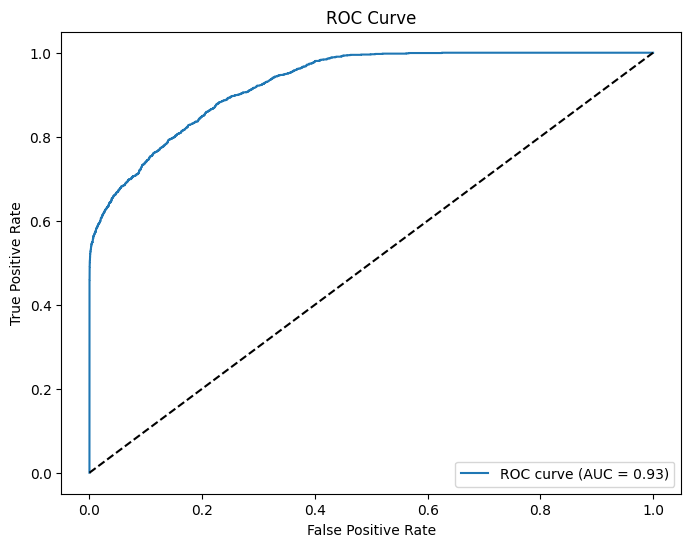

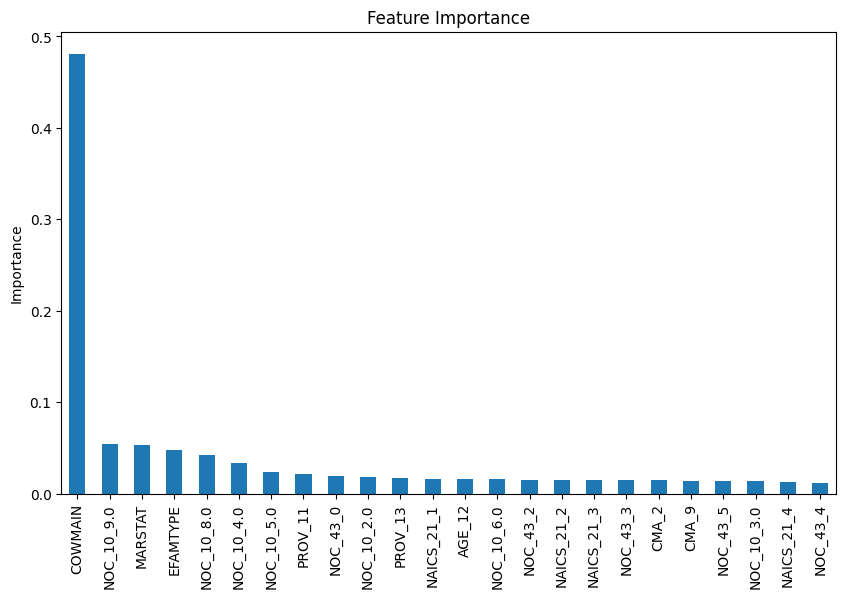

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, ...),
 0.9671612171612172,
 np.float64(0.9283312102564498),
 0.9318181818181818,
 0.5351704133430022,
 0.6798710271764163,
 array([[19731,    54],
        [  641,   738]]))

In [45]:
print("Final evaluation on test set for XGBoost + no imputation + highest features")
X_train, X_test, y_train, y_test = data_splitting(df,df['LFSSTAT'],42)
encode_hot()
encode_binary()
X_train,X_test = X_train[highest_features],X_test[highest_features]
xgboost_evaluate(print_feature_importance=True)